In [1]:
import pandas as pd
import numpy as np
import os
import json
import re
from hashlib import sha512
from vega import VegaLite
from wordcloud import WordCloud
from IPython.display import display

def display_vg(spec):
    bundle = {}
    bundle['application/vnd.vegalite.v2+json'] = spec
    display(bundle, raw=True)
    
def mkdir(directory):
    """
    :param string directory: 
    :return: 
    """
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
def save_file(file_name, data):
    with open(file_name, "w") as f:
        f.write(data)
        

In [2]:
mkdir("../data/generated/")
mkdir("../data/generated/images")

In [2]:
def get_modules(root):
    modules = [item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item))]
    
    return modules

modules = get_modules("../data/raw/modules")

modules

['CSC-10032',
 'CSC-10035',
 'CSC-20002',
 'CSC-30002',
 'CSC-10034',
 'CSC-20004',
 'MAT-40004',
 'MAT-40003',
 'MAT-20005',
 'MAT-30034',
 'MAT-30033',
 'MAT-30002',
 'MAT-20032',
 'MAT-20004',
 'MAT-30004',
 'CSC-40050',
 'MAT-10051',
 'MAT-30032',
 'CSC-40044',
 'MAT-20028',
 'MAT-10043',
 'CSC-40042',
 'CSC-40045',
 'MAT-30011',
 'MAT-30016',
 'MAT-30029',
 'MAT-20029',
 'MAT-20016',
 'CSC-30021',
 'CSC-30019',
 'MAT-40010',
 'CSC-20021',
 'CSC-10029',
 'CSC-30016',
 'CSC-30018',
 'CSC-30020',
 'CSC-10026',
 'CSC-20037',
 'MAT-40008',
 'CSC-20038',
 'MAT-40009',
 'MAT-30030',
 'MAT-30037',
 'MAT-30001',
 'MAT-30039',
 'MAT-20008',
 'CSC-40039',
 'MAT-30038',
 'MAT-00006',
 'CSC-40038',
 'MAT-20031',
 'MAT-20025',
 'MAT-30013',
 'MAT-30014',
 'MAT-10046',
 'MAT-20023',
 'CSY-30001',
 'MAT-10047',
 'MAT-30024',
 'CSC-40046',
 'MAT-30023',
 'CSC-40041',
 'MAT-10049',
 'CSC-20022',
 'MAT-40014',
 'MAT-40013',
 'CSC-30025',
 'CSC-30022',
 'CSC-20024',
 'MAT-40012',
 'CSC-20023',
 'CSC-

In [6]:
module = "CSC-30016"
print(module)
# mkdir("../data/generated/images/{0}".format(module))

output = {}
output["module_code"] = module

def get_grades(module):
    file = '../data/raw/modules/{0}/grades.csv'.format(module)
    with open(file, "r") as f:
        fline = f.readline()
        assessment_weights = [int(weight)/100 for weight in re.findall(r"\((.*?)%\)", fline)]
        
    grades = pd.read_csv(file, skiprows=[0])
    grades = grades[['#Ass#', 'Mark', '#Cand Key']]
    grades.columns = ['ass', 'grade', 'user']
    grades['user'] = grades['user'].str.replace(r'#|/[0-9]', '').apply(lambda u: sha512(u.encode('utf-8')).hexdigest())
    grades = grades.set_index('user')

    assessments = grades['ass'].unique()
    module_grades = pd.DataFrame([], index=grades.index.unique())

    for k, ass in enumerate(assessments):
        assessment_grades = grades[grades['ass'] == ass]['grade'].to_frame()
        assessment_grades.columns = [ass]
        assessment_grades['{0}_weighted'.format(ass)] = assessment_grades[ass] * assessment_weights[k]
        module_grades = module_grades.merge(assessment_grades, left_index=True, right_index=True, how="outer")

    module_grades = module_grades.fillna(0)
    module_grades['final_grade'] = module_grades.filter(regex="_weighted").sum(axis=1)
    
    return module_grades

def get_year_and_semester(module):
    file = '../data/raw/modules/{0}/grades.csv'.format(module)
    grades = pd.read_csv(file, skiprows=[0])
    
    return (grades.iloc[0]['Year'], grades.iloc[0]['Period'])

year, semester = get_year_and_semester(module)
output["year"] = year
output["semester"] = re.sub(r"SEM", "", semester)
module_grades = get_grades(module)

output["num_students"] = module_grades.shape[0]
module_grades.head()

CSC-30016


FileNotFoundError: File b'../data/raw/modules/CSC-30016/grades.csv' does not exist

In [7]:
height = 400
width = 800

def build_grade_histogram(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module attainment histogram",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "bar",
                "encoding": {
                    "x": {
                        "bin": { "step": 10 },
                        "field": "final_grade",
                        "type": "quantitative",
                        "axis": { "title": "Grade", "tickCount": 10 },
                        "scale": { "domain": [0, 100]}
                    },
                    "y": {
                        "aggregate": "count",
                        "type": "quantitative",
                        "axis": { "title": "Number of students" }
                    },
                    "color": {
                        "bin": { "step": 10 },
                        "field": "final_grade",
                        "type": "quantitative",
                        "legend": None
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 40
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": width/100 * 60
                    },
                    "size": {
                        "value": 2
                    },
                    "color": {
                        "value": "#ccc"
                    }
                }
            }
        ]
    }, data)

chart = build_grade_histogram(height, width, module_grades)
output["hist"] = chart.spec

display_vg(chart.spec)

NameError: name 'module_grades' is not defined

In [8]:
def get_grade_stats(grades):
    stats = {}
    stats["median"] = round(grades['final_grade'].median(), 1)
    stats["gte70"] = int(grades[grades['final_grade'] >= 70]['final_grade'].count())
    stats["gte60"] = int(grades[grades['final_grade'] >= 60]['final_grade'].count() - stats["gte70"])
    stats["lte40"] = int(grades[grades['final_grade'] <= 40]['final_grade'].count())
    stats["zeros"] = int(grades[grades['final_grade'] == 0]['final_grade'].count())

    return stats

output["stats"] = get_grade_stats(module_grades)

output["stats"]

{'median': 73.8, 'gte70': 42, 'gte60': 14, 'lte40': 10, 'zeros': 2}

In [9]:
all_grades = [get_grades(module)["final_grade"] for module in modules]
average_grades = pd.DataFrame(pd.concat(all_grades, axis=1).mean(axis=1), columns=["average_grade"])
# random averages
# average_grades = pd.DataFrame((np.random.random_sample(module_grades.shape[0]) * 100).round(1), columns=["average_grade"], index=module_grades.index)
compare_grades = module_grades.merge(average_grades, left_index=True, right_index=True, how="left")

compare_grades.head()

,#01,#01_weighted,#02,#02_weighted,final_grade,average_grade
user,,,,,,
0a628068de9c2a70f8685e318f5dbd07badc53704c8d7655949fda7415f195ec98c3a4d43e3957661f2fd0fce73b4814b58cf552cd35d1865cf6bf42f3e69565,96.0,76.8,89,17.8,94.6,94.6
0a6d48869596d53488f8838878198bf3caac38548d83ad7e14734297de4253f8199a814b7db1bab6091835250c7bdcc75acc14a1572f112a3967c79b1503013e,64.0,51.2,95,19.0,70.2,70.2
0a8e012a21baf4c32928caa65c149c2afd8a970a7a28820b215decefbe66778c28ae0af71c47544033919fb74846139140f9ec20dd5d8350cd3bcef2155391ff,85.0,68.0,83,16.6,84.6,84.6
18e4e11be10aaf08723ffb8f2f731ffb96d9ebdc5f38368f4b2f1e46b5f85a919d3f60d2daafcb07ead56fe24bfa63f6d13eff337a1e5f0b550c609e918bd8dc,79.0,63.2,87,17.4,80.6,80.6
1a70e13e29d382e20adf383c93d02fed2bf9b1855867b0d22415c983e81e7750f6da13abf1523d908362d4a5c8faff44b303f1c6b1572f0acf2013608633fc02,95.0,76.0,91,18.2,94.2,94.2


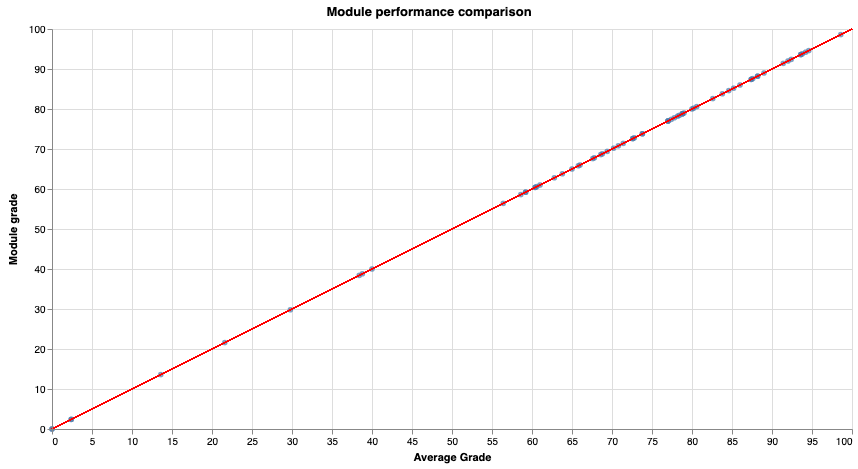

In [10]:
def build_grade_comparison_plot(height, width, data):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": "Module performance comparison",
        "height": height,
        "width": width,
        "layer": [
            {
                "mark": "circle",
                "encoding": {
                    "x": {
                        "field": "average_grade",
                        "type": "quantitative",
                        "axis": { "title": "Average Grade" },
                        "scale": { "domain": [0, 100]}
                    },
                    "y": {
                        "field": "final_grade", 
                        "typs": "quantitative",
                        "axis": { "title": "Module grade" },
                        "scale": { "domain": [0, 100]}
                    }
                }
            },
            {
                "mark": "rule",
                "encoding": {
                    "x": {
                        "value": 0
                    },
                    "y": {
                        "value": height
                    },
                    "size": {
                        "value": 1
                    },
                    "color": {
                        "value": "red"
                    }
                }
            }
        ]
    }, data)
        
chart = build_grade_comparison_plot(height, width, compare_grades)
output["compare"] = chart.spec

display_vg(chart.spec)

## Multiple choice questions

In [8]:
mc_options = [
    "Strongly Agree",
    "Agree",
    "Disagree",
    "Strongly Disagree",
    "N/A"
]

def get_student_multi_choice_feedback(module, answers):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fbq = pd.DataFrame(fb.filter(regex=r"^\d\.", axis=1))
    fbq = fbq.drop(fbq.columns[len(fbq.columns)-2:], axis=1)

    fb_answers = pd.DataFrame(fbq.apply(pd.value_counts))
    answers = pd.DataFrame(answers, columns=["answer"])
    answers = pd.DataFrame(answers).merge(fb_answers, left_on="answer", right_index=True, how="left").fillna(0)
    answers.columns = ["answer"] + ["q{0}".format(i+1) for i in range(len(fbq.columns))]
    
    return fbq.columns.tolist(), answers

sfbq, sfba = get_student_multi_choice_feedback(module, mc_options)

sfba

,answer,q1,q2,q3,q4,q5,q6
0,Strongly Agree,0.0,0.0,0.0,0.0,0.0,0.0
1,Agree,1.0,1.0,1.0,0.0,1.0,0.0
2,Disagree,0.0,0.0,0.0,1.0,0.0,1.0
3,Strongly Disagree,0.0,0.0,0.0,0.0,0.0,0.0
4,N/A,0.0,0.0,0.0,0.0,0.0,0.0


## Additional comments for multiple choice questions

In [9]:
def get_textual_student_feedback(module):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.filter(regex=r"additional comments", axis=1)
    
    text_fb = []
    for col in fb:
        text_fb.append(fb[col].dropna().drop_duplicates().tolist())
    
    return text_fb
    
get_textual_student_feedback(module)

[[], [], [], [], [], []]

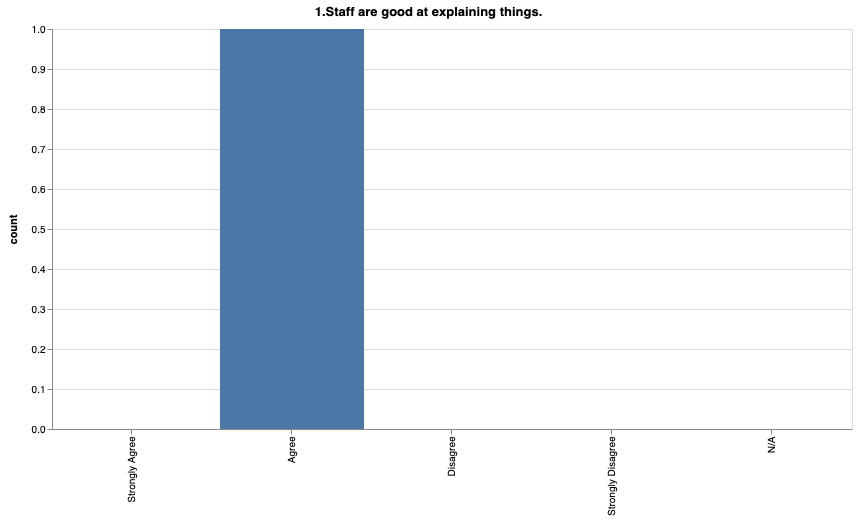

In [10]:
def build_student_feedback_histogram(height, width, data, questions, question):
    return VegaLite({
        "$schema": "https://vega.github.io/schema/vega-lite/v2.0.json",
        "title": re.sub(r"\d.\s", "", questions[question-1]),
        "height": height,
        "width": width,
        "mark": "bar",
        "encoding": {
            "x": {
                "field": "answer",
                "type": "nominal",
                "sort": None,
                "axis": { "title": "" }
            },
            "y": {
                "field": "q{0}".format(question),
                "type": "quantitative",
                "axis": { "title": "count" }
            },
            "color": {
                "field": "answer",
                "type": "nominal",
                "legend": None,
            }
        }
    }, data)

chart = build_student_feedback_histogram(height, width, sfba, sfbq, 1)
output["feedback"] = chart.spec

display_vg(chart.spec)

## Descriptive questions

In [11]:
def get_descriptive_student_feedback(module):
    fb = pd.read_csv("../data/raw/modules/{0}/feedback.csv".format(module))
    fb = fb.drop(fb.columns[0:-2], axis=1)

    desc_fb = []
    for col in fb:
        desc_fb.append(fb[col].dropna())

    return fb.columns.tolist(), desc_fb
    
dfbq, dfba = get_descriptive_student_feedback(module)
dfba

[0    .
 Name: 7. Was there anything in particular which you enjoyed in this module?, dtype: object,
 0    .
 Name: 8. If you could improve one thing about this module, what would it be?, dtype: object]

In [15]:
def build_word_cloud(text):
    return WordCloud(background_color="black", colormap="GnBu", height=height, width=width, font_path="../fonts/caveat.ttf").generate(text)

try:
    wordcloud = build_word_cloud(dfba[0].str.cat(sep=" "))
    wordcloud.to_image()
    # wordcloud.to_file("../data/generated/images/{0}/{1}.png".format(module, desc_questions[0][0]))
except(ValueError):
    print("wordcloud could not be created")

wordcloud could not be created


## Staff feedback

In [14]:
def get_staff_feedback(module):
    fb = pd.read_csv("../data/raw/staff-feedback.csv")
    mfb = fb[fb["Module Code"] == module]
    if len(mfb) < 1:
        return None
    return mfb.drop(["Timestamp", "Email address", "Module Code", "Module Name"], axis=1).iloc[0].to_dict()

staff_fb = get_staff_feedback(module)

output["staff_feedback"] = staff_fb
staff_fb

{'Are you planning to make a minor amendment to your module?': 'No.',
 'Do you have any further comments?': 'No.',
 'Do you have any good practice that you would like to share?': 'None that I have not shared in previous module reviews.',
 'Module tutor(s)': 'Martyn Parker',
 'What, in your opinion, could be improved (including details of planned changes for next year)?': 'This module will no longer run. Next year a new year-long 30 credit module replaces both Investigations and Problem Solving (IPS) and Applicable Mathematics (AM). This new module combines elements of the two old 15 credit modules. \n\n1) The new 30 credit module will provide more time for formative work aligned to the summative assessments. There will be greater emphasis on producing electronic mathematics using suitable computer packages.\n\n2) The journals will be reworked to adapt the current 4Rs reflective module and the use of PebblePad to record student reflections aligned to the KUSP.\n\n3) Although the new 30 

In [15]:
# save_file("../data/generated/{0}.json".format(module), json.dumps(output))
# output